**import important libararies**

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import files
import io
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

**method for reading data file**

In [ ]:
def read_data(file_name):
  data = files.upload()
  df = pd.read_csv(io.BytesIO(data[file_name]))
  return df

In [ ]:
df = read_data('cicids_static_data.csv')

Saving cicids_static_data.csv to cicids_static_data.csv


In [ ]:
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,159,2,2,68,266,34,34,34.000000,0.000000,133,133,133.00,0.000000,2.100629e+06,25157.232700,5.300000e+01,9.006664e+01,157,1,1,1.000,0.000000e+00,1,1,1,1.000000e+00,0.000000e+00,1,1,0,0,0,0,40,40,12578.616350,12578.616350,34,133,73.600000,54.224533,2940.30000,0,0,0,0,0,0,0,0,1,92.000000,34.000000,133.00,40,0,0,0,0,0,0,2,68,2,266,-1,-1,1,20,0.00000,0.0000,0,0,0.000,0.000,0,0,BENIGN
1,53,51673,2,2,90,166,45,45,45.000000,0.000000,83,83,83.00,0.000000,4.954231e+03,77.409866,1.722433e+04,2.982736e+04,51666,3,4,4.000,0.000000e+00,4,4,3,3.000000e+00,0.000000e+00,3,3,0,0,0,0,64,64,38.704933,38.704933,45,83,60.200000,20.813457,433.20000,0,0,0,0,0,0,0,0,1,75.250000,45.000000,83.00,64,0,0,0,0,0,0,2,90,2,166,-1,-1,1,32,0.00000,0.0000,0,0,0.000,0.000,0,0,BENIGN
2,7496,43,1,1,0,6,0,0,0.000000,0.000000,6,6,6.00,0.000000,1.395349e+05,46511.627910,4.300000e+01,0.000000e+00,43,43,0,0.000,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,20,23255.813950,23255.813950,0,6,2.000000,3.464102,12.00000,0,0,0,1,0,0,0,0,1,3.000000,0.000000,6.00,40,0,0,0,0,0,0,1,0,1,6,29200,0,0,40,0.00000,0.0000,0,0,0.000,0.000,0,0,ATTACK
3,46564,61,1,1,6,6,6,6,6.000000,0.000000,6,6,6.00,0.000000,1.967213e+05,32786.885250,6.100000e+01,0.000000e+00,61,61,0,0.000,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,20,20,16393.442620,16393.442620,6,6,6.000000,0.000000,0.00000,0,0,0,0,1,1,0,0,1,9.000000,6.000000,6.00,20,0,0,0,0,0,0,1,6,1,6,440,307,0,20,0.00000,0.0000,0,0,0.000,0.000,0,0,BENIGN
4,80,69,2,0,0,0,0,0,0.000000,0.000000,0,0,0.00,0.000000,0.000000e+00,28985.507250,6.900000e+01,0.000000e+00,69,69,69,69.000,0.000000e+00,69,69,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,0,28985.507250,0.000000,0,0,0.000000,0.000000,0.00000,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.00,40,0,0,0,0,0,0,2,0,0,0,251,-1,0,20,0.00000,0.0000,0,0,0.000,0.000,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25186,50100,197,1,1,6,6,6,6,6.000000,0.000000,6,6,6.00,0.000000,6.091371e+04,10152.284264,1.970000e+02,0.000000e+00,197,197,0,0.000,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,20,20,5076.142132,5076.142132,6,6,6.000000,0.000000,0.00000,0,0,0,0,1,1,0,0,1,9.000000,6.000000,6.00,20,0,0,0,0,0,0,1,6,1,6,62,256,0,20,0.00000,0.0000,0,0,0.000,0.000,0,0,BENIGN
25187,3390,48,1,1,0,6,0,0,0.000000,0.000000,6,6,6.00,0.000000,1.250000e+05,41666.666670,4.800000e+01,0.000000e+00,48,48,0,0.000,0.000000e+00,0,0,0,0.000000e+

## Shows columns'names of the dataset

In [ ]:
print(df.columns)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

## Show number of records in the dataset dataframe

In [ ]:
print(len(df))

25191


## Get the rows which contains null values, which are equal to 6 rows

In [ ]:
def get_rows_with_null(dataset):
  is_NaN = dataset.isnull()
  row_has_NaN = is_NaN.any(axis=1)
  rows_with_NaN = dataset[row_has_NaN]
  return rows_with_NaN

In [ ]:
na_rows = get_rows_with_null(df)
print(na_rows)

        Destination Port   Flow Duration  ...   Idle Min   Label
2845               18467               0  ...          0  BENIGN
3979               56989               0  ...          0  BENIGN
4241               51540               0  ...          0  BENIGN
16927                 80               0  ...          0  ATTACK
21134                 80               0  ...          0  ATTACK
21962                 80               0  ...          0  ATTACK

[6 rows x 79 columns]


## Get the column/s name which contain null values, which is "Flow Bytes/s" column

In [ ]:
def get_col_with_null(dataset):
  nan_values = dataset.isna()
  nan_columns = nan_values.any()
  columns_with_nan = dataset.columns[nan_columns].tolist()
  return columns_with_nan

In [ ]:
na_col = get_col_with_null(df)
print(na_col)

['Flow Bytes/s']


**See the discribtion of the column which contains null values "Flow Bytes/s" column**

In [ ]:
df['Flow Bytes/s'].describe()

count    2.518500e+04
mean              inf
std               NaN
min     -1.200000e+07
25%      1.194258e+02
50%      4.717414e+03
75%      1.860465e+05
max               inf
Name: Flow Bytes/s, dtype: float64

## Create a Series which contains:
### 1- For every column which has inf values (True),
### 2- For every column which has not inf values (False)

## It shows that 2 columns contain inf values

## Crete a list of columns names which contain inf values in the dataframe

In [ ]:
def get_inf_col(dataset):
  col_inf = dataset[dataset==float("inf")].any()
  inf_list = []
  for i in range(len(col_inf)):
    if(col_inf[i] == True):
      inf_list.append(dataset.columns[i])

  return inf_list

In [ ]:
inf_col = get_inf_col(df)
print(inf_col)

['Flow Bytes/s', ' Flow Packets/s']


## Replace each inf value with the median of its column

In [ ]:
def replace_inf_median(inf_list, dataset):
  for i in inf_list:
    for j in range(len(dataset[i])):
      if(dataset[i][j] == float("inf")):
        dataset[i][j] = dataset[i].median()# replace each inf value with he median of the column

  return dataset

In [ ]:
df = replace_inf_median(inf_col, df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Replace null values with the mean of its column

In [ ]:
def replace_na_mean(columns_with_nan, dataset):
  #replace nan values with the mean of the column
  dataset[columns_with_nan] = dataset[columns_with_nan].fillna((dataset[columns_with_nan].mean()))
  return dataset

In [ ]:
df = replace_na_mean(na_col, df)

## **It is obvious that the data is imbalanced**
## As we have 22744 record for BENIGN class, and only 2447 record for ATTACK class.
## And we have our concern on ATTACK class, so there is imbalanced.

In [ ]:
df.Label.value_counts()

BENIGN    22744
ATTACK     2447
Name: Label, dtype: int64

## Get features in a separate variable X

In [ ]:
X = df.drop(labels = ["Label"], axis=1) 
len(X)

25191

## Get labels in a separate variable y

In [ ]:
y = df["Label"].values
len(y)

25191

### Plot graph to ahow the difference between benign and attack classes samples

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


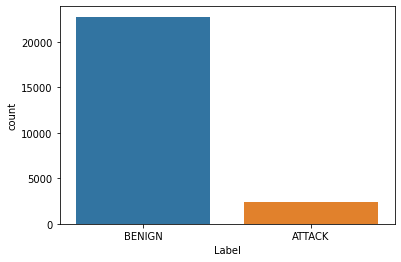

In [ ]:
g = sns.countplot(df['Label'])
g.set_xticklabels(['BENIGN','ATTACK'])
plt.show()

## The data values have a high difference in values. So, I will scale data using standardscaler

In [ ]:
#scale the data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# Apply Boruta model to select only important features

**Define RandomForestClassifier to be used by Boruta**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5)

In [ ]:
pip install boruta

     |████████████████████████████████| 56 kB 3.1 MB/s 


In [ ]:
from boruta import BorutaPy

**Train Boruta model**

In [ ]:
# makes the model runs for 150 iteration as a maximum.
# If the model reaches all important features before that, then stop early.
trans = BorutaPy(clf, n_estimators = 'auto', random_state=42, verbose=2, max_iter = 150)
sel = trans.fit_transform(X_scaled, y)

Iteration: 	1 / 150
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	2 / 150
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	3 / 150
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	4 / 150
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	5 / 150
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	6 / 150
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	7 / 150
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	8 / 150
Confirmed: 	64
Tentative: 	2
Rejected: 	12
Iteration: 	9 / 150
Confirmed: 	64
Tentative: 	2
Rejected: 	12
Iteration: 	10 / 150
Confirmed: 	64
Tentative: 	2
Rejected: 	12
Iteration: 	11 / 150
Confirmed: 	64
Tentative: 	2
Rejected: 	12
Iteration: 	12 / 150
Confirmed: 	65
Tentative: 	1
Rejected: 	12
Iteration: 	13 / 150
Confirmed: 	65
Tentative: 	1
Rejected: 	12
Iteration: 	14 / 150
Confirmed: 	65
Tentative: 	1
Rejected: 	12
Iteration: 	15 / 150
Confirmed: 	65
Tentative: 	1
Rejected: 	12
Iteration: 	16 / 150
Confirmed: 	66
Tentative: 	0
Reject

**As an output from boruta, we have 66 important features (those which have True value)**

In [ ]:
# important features will have true value
# rejected features will have false value
print(trans.support_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True False False  True  True  True  True  True False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


**Apply feature reduction in X data**

In [ ]:
# use data with only important fratures, not all features
X_scaled_fea = trans.transform(X_scaled)

dff = pd.DataFrame(X_scaled_fea)
dff

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,-0.456709,-0.408008,-0.010138,-0.009138,-0.066495,-0.008165,-0.251521,0.223876,-0.146581,-0.246788,-0.331920,1.237593,-0.208517,-0.363955,0.015772,-0.171987,-0.257762,-0.317464,-0.340231,-0.058020,-0.399060,-0.238805,-0.296612,-0.331369,-0.126741,-0.346948,-0.197757,-0.234638,-0.273009,-0.122562,-0.226472,-0.011691,-0.010252,-0.202654,0.145132,0.602931,-0.361647,-0.261560,-0.333513,-0.235997,-0.165298,-0.226472,-0.624194,-0.657792,-0.344031,0.468711,-0.238709,-0.146581,-0.208517,-0.011691,-0.010138,-0.066495,-0.009138,-0.008166,-0.476874,-0.253533,-0.008265,-0.915204,-0.097581,-0.113809,-0.135019,-0.071521,-0.312637,-0.096307,-0.316221,-0.301291
1,-0.456709,-0.406394,-0.010138,-0.009138,-0.063658,-0.008193,-0.236641,0.405659,-0.089183,-0.246788,-0.365667,0.528523,-0.314330,-0.363955,-0.059490,-0.275646,-0.253876,-0.313352,-0.337700,-0.058019,-0.399059,-0.238805,-0.296612,-0.331369,-0.126741,-0.346948,-0.197757,-0.234638,-0.273009,-0.122562,-0.226472,-0.010728,-0.009511,-0.256294,-0.174980,1.023327,-0.392778,-0.314553,-0.400695,-0.238018,-0.165298,-0.226472,-0.624194,-0.657792,-0.344031,0.468711,-0.299984,-0.089183,-0.314330,-0.010728,-0.010138,-0.063658,-0.009138,-0.008193,-0.476874,-0.253533,-0.008265,0.949275,-0.097581,-0.113809,-0.135019,-0.071521,-0.312637,-0.096307,-0.316221,-0.301291
2,-0.066558,-0.408012,-0.010957,-0.009755,-0.075261,-0.008237,-0.297515,-0.337998,-0.323994,-0.246788,-0.417637,-0.563447,-0.477281,-0.363955,-0.054656,-0.083727,-0.257764,-0.317476,-0.340237,-0.058005,-0.399060,-0.238805,-0.296612,-0.331369,-0.126741,-0.346948,-0.197758,-0.234638,-0.273009,-0.122562,-0.226472,-0.011691,-0.010869,-0.156982,0.417695,-0.696476,-0.440722,-0.544715,-0.435581,-0.238357,-0.165298,-0.226472,1.602066,-0.657792,-0.344031,0.468711,-0.564287,-0.323994,-0.477281,-0.011691,-0.010957,-0.075261,-0.009755,-0.008237,1.492980,-0.253425,-0.009113,2.192261,-0.097581,-0.113809,-0.135019,-0.071521,-0.312637,-0.096307,-0.316221,-0.301291
3,1.981326,-0.408011,-0.010957,-0.009755,-0.074487,-0.008237,-0.289398,-0.238844,-0.292686,-0.246788,-0.417637,-0.563447,-0.477281,-0.363955,-0.052603,-0.140453,-0.257760,-0.317476,-0.340236,-0.057998,-0.399060,-0.238805,-0.296612,-0.331369,-0.126741,-0.346948,-0.197758,-0.234638,-0.273009,-0.122562,-0.226472,-0.012493,-0.010869,-0.186336,0.242515,-0.467169,-0.440722,-0.528896,-0.442546,-0.238367,-0.165298,-0.226472,-0.624194,1.520237,2.906714,0.468711,-0.542338,-0.292686,-0.477281,-0.012493,-0.010957,-0.074487,-0.009755,-0.008237,-0.447125,-0.220153,-0.009113,-0.915204,-0.097581,-0.113809,-0.135019,-0.071521,-0.312637,-0.096307,-0.316221,-0.301291
4,-0.455294,-0.408011,-0.010138,-0.010373,-0.075261,-0.008239,-0.297515,-0.337998,-0.323994,-0.246788,-0.421687,-0.648535,-0.489978,-0.363955,-0.059667,-0.156165,-0.257758,-0.317476,-0.340235,-0.057995,-0.399057,-0.238798,-0.296612,-0.331366,-0.126734,-0.346948,-0.197758,-0.234638,-0.273009,-0.122562,-0.226472,-0.011691,-0.011486,-0.132473,-0.175968,-0.696476,-0.444457,-0.552624,-0.442546,-0.238367,-0.165298,-0.226472,-0.624194,1.520237,-0.344031,-1.032535,-0.575262,-0.323994,-0.489978,-0.011691,-0.010138,-0.075261,-0.010373,-0.008239,-0.459875,-0.253533,-0.009113,-0.915204,-0.097581,-0.113809,-0.135019,-0.071521,-0.312637,-0.096307,-0.316221,-0.301291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25186,2.166677,-0.408007,-0.010957,-0.009755,-0.074487,-0.008237,-0.289398,-0.238844,-0.292686,-0.246788,-0.417637,-0.563447,-0.477281,-0.363955,-0.057480,-0.234005,-0.257729,-0.317476,-0.340229,-0.057950,-0.399060,-0.238805,-0.296612,-0.331369,-0.126741,

## Split the data into train and test by 80% : 20%

In [ ]:
#split the data into train and test.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_fea, y, test_size=0.20, stratify=y)

## Reach balance case with classes samples use smotetomek
### I used that method andget results,but later on I decided to work with the data without sampling. But, it will run successfully if you remove comments on code lines.

In [ ]:
# sm = SMOTETomek()
# X_train, y_train = sm.fit_resample(X_train, y_train)

## Initialize decision tree object and see its performance on 10 folds crossvalidation

In [ ]:
clf_1 = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(clf_1, X_train, y_train, cv=10)

**The model reach average performance with score = 99.72%**

In [ ]:
# get the average scorefrom the list of scores from crossvalidations
avg = sum(scores)/len(scores)
print(avg)

0.997121858875891


In [ ]:
scores

array([0.99603175, 0.9985119 , 0.99652605, 0.99751861, 0.99652605,
       0.99652605, 0.99702233, 0.99801489, 0.99454094, 1.        ])

## Fit the model with training data after being balanced

In [ ]:
clf_1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

## Get model prediction on testing data

In [ ]:
pred = clf_1.predict(X_test)

###  Get Decision Tree model prediction probabilities to be used in ROC curve later

In [ ]:
pred_proba = clf_1.predict_proba(X_test)[::,1]

**Modelaccuracy ==> 99.72%**

In [ ]:
accuracy_score(y_test, pred)

0.9970232188926375

### Print classification report of the model

In [ ]:
clf_rep = classification_report(y_test, pred)
print(clf_rep)

              precision    recall  f1-score   support

      ATTACK       0.98      0.99      0.98       489
      BENIGN       1.00      1.00      1.00      4550

    accuracy                           1.00      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       1.00      1.00      1.00      5039



## Get the confusion matrix for the model prediction on testing data

In [ ]:
confusion_matrix(y_test, pred)

array([[ 484,    5],
       [  10, 4540]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


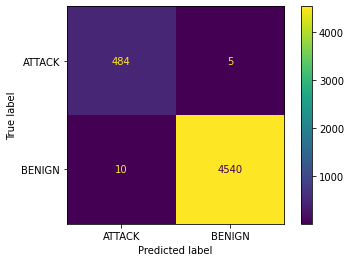

In [ ]:
plot_confusion_matrix(clf_1, X_test, y_test)  
plt.show()

## Save model to test its performance on streaming datafrom kafka server

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(clf_1, open(filename, 'wb'))

## Use another model **KNN** to see its performance on the static data

### Initialize decision tree object and see its performance on 10 folds crossvalidation

In [ ]:
clf_2 = KNeighborsClassifier(n_jobs=-1)
scores_2 = cross_val_score(clf_2, X_train, y_train, cv=10)

**The model reach average performance with score = 98.69%**

In [ ]:
# get the average scorefrom the list of scores from crossvalidations
avg_2 = sum(scores_2)/len(scores_2)
print(avg_2)

0.9873957964078933


In [ ]:
print(scores_2)

[0.98660714 0.98809524 0.99007444 0.98709677 0.98759305 0.98560794
 0.9866005  0.98610422 0.9866005  0.98957816]


### Fit KNN model with training data after being balanced. And get its prediction for testing data.

In [ ]:
clf_2.fit(X_train, y_train)
pred_2 = clf_2.predict(X_test)

###  Get KNN model prediction probabilities to be used in ROC curve later

In [ ]:
pred_proba_2 = clf_2.predict_proba(X_test)[::,1]

### KNN accuracy and classification report

In [ ]:
accuracy_score(y_test, pred_2)

0.9867037110537805

In [ ]:
clf_rep_2 = classification_report(y_test, pred_2)
print(clf_rep_2)

              precision    recall  f1-score   support

      ATTACK       0.94      0.92      0.93       489
      BENIGN       0.99      0.99      0.99      4550

    accuracy                           0.99      5039
   macro avg       0.97      0.96      0.96      5039
weighted avg       0.99      0.99      0.99      5039



## Get the confusion matrix for the model prediction on testing data

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


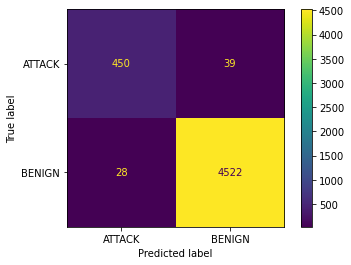

In [ ]:
plot_confusion_matrix(clf_2, X_test, y_test)  
plt.show()

### Get the traffic labels as numbers (0, 1) in an array that will be used in plotting ROC curve

In [ ]:
yy_test = []
for i in range(len(y_test)):
  if(y_test[i]=='BENIGN'):
    y_test[i] = 0
  else:
    y_test[i] = 1

  yy_test.append(y_test[i])

## Method which plots ROC curve for both models

In [ ]:
def plot_roc(pred_proba, pred_proba_2, y_test):
  # TPR, FPR, Thrshold for both models Decision Tree and KNN
  fpr_1, tpr_1, thresh_1 = roc_curve(y_test, pred_proba, pos_label=0)
  fpr_2, tpr_2, thresh_2 = roc_curve(y_test, pred_proba_2, pos_label=0)

  # tpr, fpr, threshold for random classifer 
  random_probs = [0 for i in range(len(y_test))]
  fpr_r, tpr_r, thresh_r = roc_curve(y_test, random_probs, pos_label=0)

  plt.style.use('seaborn')
  plt.plot(fpr_1, tpr_1, linestyle='--',color='red', label='Decision Tree')
  plt.plot(fpr_2, tpr_2, linestyle='--',color='green', label='KNN')
  plt.plot(fpr_r, tpr_r, linestyle='--', color='blue')

  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')

  plt.legend(loc='best')
  plt.savefig('ROC Curve',dpi=300)
  plt.show()

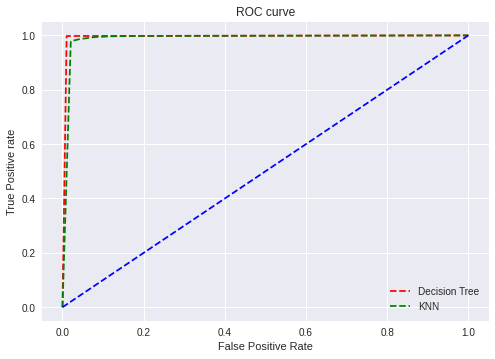

In [ ]:
# plot ROC curve from both models decision tree, and knn
plot_roc(pred_proba, pred_proba_2, yy_test)

## References:
### - Categorical, C., 2015. Check which columns in DataFrame are Categorical. [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical>
### - scikit-learn. 2021. sklearn.ensemble.AdaBoostClassifier. [online] Available at: <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html>
### - Analytics India Magazine. 2021. Hands-On Guide To Automated Feature Selection Using Boruta. [online] Available at: <https://analyticsindiamag.com/hands-on-guide-to-automated-feature-selection-using-boruta/>